In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("device: ", device)

torch.__version__

device:  cuda


'2.5.1'

In [65]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Константы
num_trajectories = 10  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'last_data'  # Путь к данным
input_features = ['x_measure', 'y_measure', 'z_measure',
                  'v_x_measure', 'v_y_measure', 'v_z_measure',

                  'r_measure', 'theta_measure', 'fi_measure',
                  'v_r_measure', 'v_theta_measure', 'v_fi_measure',

                  # 'r_mean', 'theta_mean', 'fi_mean',
                  'r_error', 'theta_error', 'fi_error',
                  ]  # Входные признаки

# input_features = ['x_measure', 'v_x_measure', 'r_measure', 'theta_measure', 'fi_measure',
#                   'r_error', 'theta_error', 'fi_error']  # Входные признаки

# input_features = ['x_measure']
target_feature = 'x_true'  # Целевая координата
to_avg = 'r_true'

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []
r_true = []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
        r_true.append(data[to_avg].values)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, num_radars, seq_length)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)

print(X_data.shape) 
print(y_data.shape)  


(10, 16, 1001, 15)
(10, 16, 1001)


In [66]:
import numpy as np

def calculate_sigma_x(r, theta, phi, sigma_r, sigma_theta, sigma_phi):
    """
    Вычисляет СКО для координаты x в декартовой системе.

    Параметры:
        r: Расстояние до цели (м).
        theta: Полярный угол (радианы).
        phi: Азимутальный угол (радианы).
        sigma_r: СКО по радиусу (м).
        sigma_theta: СКО по углу theta (радианы).
        sigma_phi: СКО по углу phi (радианы).

    Возвращает:
        sigma_x: СКО для координаты x (м).
    """
    # Частные производные
    dx_dr = np.sin(theta) * np.cos(phi)
    dx_dtheta = r * np.cos(theta) * np.cos(phi)
    dx_dphi = -r * np.sin(theta) * np.sin(phi)

    # Дисперсия для x
    sigma_x_squared = (
        (dx_dr * sigma_r) ** 2 +
        (dx_dtheta * sigma_theta) ** 2 +
        (dx_dphi * sigma_phi) ** 2
    )

    # СКО для x
    sigma_x = np.sqrt(sigma_x_squared)
    return sigma_x

def weighted_estimator_spherical(x: np.array, r: np.array, theta: np.array, phi: np.array,
                                sigma_r: np.array, sigma_theta: np.array, sigma_phi: np.array):
    """
    Расчет взвешенной оценки координаты x по данным от нескольких РЛС.

    Параметры:
        x: Массив измерений координаты x (м).
        r: Массив расстояний до цели (м).
        theta: Массив полярных углов (радианы).
        phi: Массив азимутальных углов (радианы).
        sigma_r: Массив СКО по радиусу (м).
        sigma_theta: Массив СКО по углу theta (радианы).
        sigma_phi: Массив СКО по углу phi (радианы).

    Возвращает:
        x_weighted: Взвешенная оценка координаты x (м).
    """
    # Вычисляем СКО для x для каждого радара
    sigma_x = np.array([
        calculate_sigma_x(r[i], theta[i], phi[i], sigma_r[i], sigma_theta[i], sigma_phi[i])
        for i in range(len(x))
    ])

    # Вычисляем веса
    v = 1 / sigma_x ** 2  # Веса как обратные квадратам СКО
    ss = np.sum(v)  # Сумма весов
    weights = v / ss  # Нормализованные веса
    # print(weights)

    # Взвешенное среднее
    x_weighted = np.sum(x * weights)
    return x_weighted

In [67]:
from tools import DynamicAlignment

Средний модуль разности между x_true и измерениями: 164.857890
Средний модуль разности между x_true и просто средним: 127.039069
Средний модуль разности между x_true и взвешенной  координатой: 125.617859
Средний модуль разности между x_true и взвешенной сглаженной координатой: 126.843155


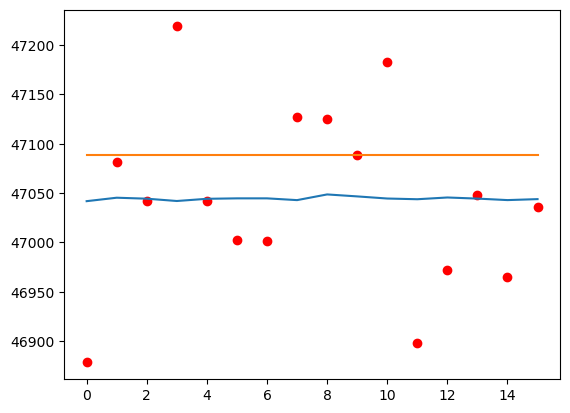

In [68]:
# Инициализация массива для хранения всех разностей
all_aligned_differences = []
all_simple_diff = []
all_weighted_diff = []
all_avg_diff = []

# Инициализация сглаживателя
smoother = DynamicAlignment(num_radars=16)

# Проходим по всем траекториям
for traj_idx in range(num_trajectories):
    trajectory_data = X_data[traj_idx]  # (16, 1000, num_features)
    trajectory_targets = y_data[traj_idx]  # (16, 1000)

    # Извлекаем необходимые данные
    x_measure = trajectory_data[:, :, 0]  # (16, 1000) - x_measure для всех радаров
    r_measure = trajectory_data[:, :, 6]  # (16, 1000) - r_measure для всех радаров
    theta_measure = trajectory_data[:, :, 7]  # (16, 1000) - theta_measure для всех радаров
    fi_measure = trajectory_data[:, :, 8]  # (16, 1000) - fi_measure для всех радаров
    r_error = trajectory_data[:, :, 12]  # (16, 1000) - r_error для всех радаров
    theta_error = trajectory_data[:, :, 13]  # (16, 1000) - theta_error для всех радаров
    fi_error = trajectory_data[:, :, 14]  # (16, 1000) - fi_error для всех радаров

    # Проходим по каждой точке (1000 точек)
    for point_idx in range(x_measure.shape[1]):
        # Извлекаем данные для текущей точки
        x_measure_point = x_measure[:, point_idx]  # (16,) - x_measure для всех радаров
        r_measure_point = r_measure[:, point_idx]  # (16,) - r_measure для всех радаров
        theta_measure_point = theta_measure[:, point_idx]  # (16,) - theta_measure для всех радаров
        fi_measure_point = fi_measure[:, point_idx]  # (16,) - fi_measure для всех радаров
        r_error_point = r_error[:, point_idx]  # (16,) - r_error для всех радаров
        theta_error_point = theta_error[:, point_idx]  # (16,) - theta_error для всех радаров
        fi_error_point = fi_error[:, point_idx]  # (16,) - fi_error для всех радаров
        # print(x_measure_point)
        

        # Вычисляем СКО для x для каждого радара
        sigma_x = np.array([
            calculate_sigma_x(r_measure_point[i], theta_measure_point[i], fi_measure_point[i],
                             r_error_point[i], theta_error_point[i], fi_error_point[i])
            for i in range(16)
        ])
        # print(sigma_x)
        
        x_weighted = weighted_estimator_spherical(
            x_measure_point, r_measure_point, theta_measure_point, fi_measure_point,
            r_error_point, theta_error_point, fi_error_point
        )

        
        # Применяем экспоненциальное сглаживание
        smoother.update_ksi(sigma_x)
        aligned_x_measure = smoother.compute_alignments(x_measure_point)

        # Вычисляем взвешенную координату x
        x_aligned_weighted = weighted_estimator_spherical(
            aligned_x_measure, r_measure_point, theta_measure_point, fi_measure_point,
            r_error_point, theta_error_point, fi_error_point
        )
        
        # print(aligned_x_measure)

        # Вычисляем модуль разности между x_true и взвешенной координатой
        x_true_point = trajectory_targets[0, point_idx]  # x_true для текущей точки (берем первый радар, так как x_true одинаков для всех радаров)
        # print(x_true_point)
        weighted_difference = abs(x_true_point - x_weighted)
        aligned_difference = abs(x_true_point - x_aligned_weighted)  # Модуль разности
        simple_diff = abs(x_true_point - x_measure_point)
        avg_diff = abs(x_true_point - np.mean(x_measure_point))
        all_aligned_differences.append(aligned_difference)
        all_simple_diff.append(simple_diff)
        all_weighted_diff.append(weighted_difference)
        all_avg_diff.append(avg_diff)
        if traj_idx == 0 and point_idx == 0:
            plt.scatter(np.arange(x_measure.shape[0]), x_measure_point, color = "red")
            plt.plot(np.arange(x_measure.shape[0]), aligned_x_measure)
            plt.plot(np.arange(x_measure.shape[0]), np.array([x_true_point for _ in range(x_measure.shape[0])]))
        
        


print(f"Средний модуль разности между x_true и измерениями: {np.mean(all_simple_diff):.6f}")
print(f"Средний модуль разности между x_true и просто средним: {np.mean(all_avg_diff):.6f}")
print(f"Средний модуль разности между x_true и взвешенной  координатой: {np.mean(all_weighted_diff):.6f}")
print(f"Средний модуль разности между x_true и взвешенной сглаженной координатой: {np.mean(all_aligned_differences):.6f}")

In [15]:
# Инициализация массива для хранения всех разностей
all_differences = []

# Проходим по всем траекториям
for traj_idx in range(num_trajectories):
    trajectory_data = X_data[traj_idx]  # (16, 1000, num_features)
    trajectory_targets = y_data[traj_idx]  # (16, 1000)

    # Извлекаем необходимые данные
    x_measure = trajectory_data[:, :, 0]  # (16, 1000) - x_measure для всех радаров
    r_measure = trajectory_data[:, :, 6]  # (16, 1000) - r_measure для всех радаров
    theta_measure = trajectory_data[:, :, 7]  # (16, 1000) - theta_measure для всех радаров
    fi_measure = trajectory_data[:, :, 8]  # (16, 1000) - fi_measure для всех радаров
    r_error = trajectory_data[:, :, 12]  # (16, 1000) - r_error для всех радаров
    theta_error = trajectory_data[:, :, 13]  # (16, 1000) - theta_error для всех радаров
    fi_error = trajectory_data[:, :, 14]  # (16, 1000) - fi_error для всех радаров

    # Проходим по каждой точке (1000 точек)
    for point_idx in range(x_measure.shape[1]):
        # Извлекаем данные для текущей точки
        x_measure_point = x_measure[:, point_idx]  # (16,) - x_measure для всех радаров
        r_measure_point = r_measure[:, point_idx]  # (16,) - r_measure для всех радаров
        theta_measure_point = theta_measure[:, point_idx]  # (16,) - theta_measure для всех радаров
        fi_measure_point = fi_measure[:, point_idx]  # (16,) - fi_measure для всех радаров
        r_error_point = r_error[:, point_idx]  # (16,) - r_error для всех радаров
        theta_error_point = theta_error[:, point_idx]  # (16,) - theta_error для всех радаров
        fi_error_point = fi_error[:, point_idx]  # (16,) - fi_error для всех радаров

        # Вычисляем взвешенную координату x
        x_weighted = weighted_estimator_spherical(
            x_measure_point, r_measure_point, theta_measure_point, fi_measure_point,
            r_error_point, theta_error_point, fi_error_point
        )

        # Вычисляем модуль разности между x_true и взвешенной координатой
        x_true_point = trajectory_targets[0, point_idx]  # x_true для текущей точки (берем первый радар, так как x_true одинаков для всех радаров)
        difference = abs(x_true_point - x_weighted)  # Модуль разности
        all_differences.append(difference)

# Усредняем модуль разности по всем точкам и траекториям
average_difference = np.mean(all_differences)
print(f"Средний модуль разности между x_true и взвешенной координатой: {average_difference:.6f}")

Средний модуль разности между x_true и взвешенной координатой: 8.360588


In [7]:
len(r_true)
np.mean([np.mean(r) for r in r_true])

np.float64(89892.83162107594)

In [8]:
np.mean(r_true[80])

np.float64(174816.87723494112)

In [10]:
train_size = int(0.8 * len(X_data))
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]
print(X_train.shape, X_test.shape)

(0, 16, 1001, 15) (1, 16, 1001, 15)


In [23]:
# 111 7
# 234 12 
# 937

class RadarDataset(Dataset):
    def __init__(self, X, y, window_size=937, step=1):
        self.windows_X = []
        self.windows_y = []
        
        for trajectory_idx in range(X.shape[0]):  # 368 траекторий
            trajectory_X = X[trajectory_idx]  # (16, 1001, 11)
            trajectory_y = y[trajectory_idx]  # (16, 1001)
            
            # Конкатенируем данные от 16 радаров
            trajectory_X = trajectory_X.transpose(1, 0, 2).reshape(1001, -1)  # (1001, 11*16)
            trajectory_y = trajectory_y.mean(axis=0)  # Среднее значение x для всех радаров (1001,)
            
            for start in range(0, 1001 - window_size, step):
                end = start + window_size
                self.windows_X.append(trajectory_X[start:end, :])
                # self.windows_y.append(trajectory_y[end-1])
                self.windows_y.append(trajectory_y[start:end])  # Берем ВСЕ точки окна

        
        self.windows_X = torch.tensor(np.array(self.windows_X), dtype=torch.float32)
        self.windows_y = torch.tensor(np.array(self.windows_y), dtype=torch.float32)
        
    def __len__(self):
        return len(self.windows_X)
    
    def __getitem__(self, idx):
        return self.windows_X[idx], self.windows_y[idx]
    


In [24]:
# from sklearn.preprocessing import StandardScaler
# import torch
# 
# # Создаем скейлеры
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# 
# # Нормализация X (признаки)
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()
# 
# for i in range(16):  # По всем радарам отдельно
#     X_train_scaled[:, i, :, :] = torch.tensor(
#         X_scaler.fit_transform(X_train[:, i, :, :].reshape(-1, 11)).reshape(1001, 11),
#         dtype=torch.float32
#     )
#     X_test_scaled[:, i, :, :] = torch.tensor(
#         X_scaler.transform(X_test[:, i, :, :].reshape(-1, 11)).reshape(1001, 11),
#         dtype=torch.float32
#     )
# 
# # Нормализация y (целевая переменная)
# y_train_scaled = torch.tensor(
#     y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape),
#     dtype=torch.float32
# )
# y_test_scaled = torch.tensor(
#     y_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape),
#     dtype=torch.float32
# )
# 
# # Теперь передаем в RadarDataset
# train_dataset = RadarDataset(X_train_scaled, y_train_scaled)
# test_dataset = RadarDataset(X_test_scaled, y_test_scaled)


In [25]:
# #################################### NORMALIZE ####################################################
# 
# from sklearn.preprocessing import StandardScaler
# 
# # Нормализуем данные
# train_scaler = StandardScaler()
# test_scaler = StandardScaler()
# # Пример нормализации для X (признаки)
# X_train_scaled = torch.tensor(train_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape), dtype=torch.float32)
# X_test_scaled = torch.tensor(test_scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape), dtype=torch.float32)
# 
# # Для y (цели) можно тоже использовать нормализацию или просто масштабировать в тот же диапазон
# y_train_scaled = torch.tensor(train_scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape), dtype=torch.float32)
# y_test_scaled = torch.tensor(test_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape), dtype=torch.float32)
# 
# print(X_train_scaled.shape)
# 
# 
# train_dataset = RadarDataset(X_train_scaled, y_train_scaled)
# test_dataset = RadarDataset(X_test_scaled, y_test_scaled)

In [26]:
# Создание датасета и DataLoader
b_size = 64
train_dataset = RadarDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False)

test_dataset = RadarDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

# Пример батча
print(len(train_loader), len(test_loader))
for X_batch, y_batch in train_loader:
    print(X_batch.shape) 
    print(y_batch.shape) 
    print(X_batch[0][233][:17], y_batch[0][233])
    break

294 74
torch.Size([64, 937, 240])
torch.Size([64, 937])
tensor([ 3.3451e+04,  1.1650e+04, -6.2469e+02,  8.7604e-02, -1.5199e-01,
        -7.4237e-02,  3.5428e+04,  1.5884e+00,  3.3514e-01,  3.4044e-02,
        -6.9600e-06, -3.2387e-06,  1.5183e+00,  2.1854e-03,  1.4503e-03,
         3.3431e+04,  1.1712e+04]) tensor(33428.6992)


In [27]:
# def make_windows(X, y, window_size, step): 
#     windows_X = []
#     windows_y = []
#     for idx in range(X.shape[0]):
#         trajectory_X = X[idx]  # (1001, 16)
#         trajectory_y = y[idx]  # (1001)
# 
#         for start in range(0, trajectory_X.shape[0] - window_size, step):
#             end = start + window_size
#             windows_X.append(trajectory_X[start:end, :])  # Окно данных
#             windows_y.append(trajectory_y[end-1])  # Целевая координата в конце окна
#     
#     windows_X = np.array(windows_X)  # (16*количество окон, 100, 16)
#     windows_y = np.array(windows_y)  # (16*количество окон,)
#     
#     return torch.tensor(windows_X, dtype=torch.float32), torch.tensor(windows_y, dtype=torch.float32)   
#     
# X_data, y_data  = make_windows(X_data_raw, y_data_raw, 234, 12) # check determ   
# print(X_data.shape) 
# print(y_data.shape) 
# print(len(X_data))

----------------------------------------------------------------------------------------- MODEL --------------------------------------------------------------------------------

In [30]:
import torch.nn as nn

# Функция инициализации весов с помощью метода Xavier
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)  # Инициализация весов
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # Инициализация смещений нулями
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Инициализация весов
        nn.init.constant_(m.bias, 0)  # Инициализация смещений нулями

class LSTMModel(nn.Module):
    def __init__(self, input_size=176, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Полносвязный слой для предсказания координаты x
        self.fc1 = nn.Linear(hidden_size, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
        # self.fc1 = nn.Linear(hidden_size, output_size)
    
    #residual
    def forward(self, x, x_measure):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)
        out = self.fc1(lstm_out)  # output: (batch, seq_len, 1)
        out = self.act1(out)
        out = self.fc2(out)
        
        return out + x_measure.unsqueeze(-1)


---------------------------------------------------------------------------------- TRAIN ----------------------------------------------------------------------------------------

In [33]:
from tqdm import tqdm
def train(model, optimizer, scheduler, criterion, loader, epochs, clip_value=1.0):
    history = []
    
    #----------------
    abs_diff  = 0
    for i, (inputs, targets) in enumerate(loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        x_measure_all = inputs[:, :, ::15]  # Берем каждый 15-й признак (x_measure от всех радаров)
        x_measure_avg = x_measure_all.mean(dim=-1)  # Усредняем по радарам
        abs_diff += torch.abs(x_measure_avg - targets).mean().item()  # Средняя абсолютная разница на батче
    abs_diff/=len(loader)
    #----------------
    
    crit = nn.L1Loss()
    
    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        l1_running = 0.0
        for i, (inputs, targets) in enumerate(loader):
        # for i, (inputs, targets) in tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch+1}/{epochs}'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            x_measure_all = inputs[:, :, ::15]  # Берем каждый 15-й признак (x_measure от всех радаров)
            x_measure_avg = x_measure_all.mean(dim=-1)  # Усредняем по радарам

            # Прогноз
            optimizer.zero_grad()
            outputs = model(inputs, x_measure_avg)
    
            # Вычисление ошибки
            loss = criterion(outputs.squeeze(), targets)
            l1 = crit(outputs.squeeze(), targets)  # Теперь shape (batch, window)

            loss.backward()
        
            # Градиентный клипинг
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
            optimizer.step()
    
            running_loss += loss.item()
            l1_running += l1.item()
            
        scheduler.step()
    
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.6f}, L1 {l1_running/len(loader):.6f}, Avg Abs Diff: {abs_diff:.6f}')
        history.append(running_loss/len(loader))
    return history, model
    

Epoch [1/400], Loss: 28863.949294, L1 119.469276, Avg Abs Diff: 121.677912
Epoch [2/400], Loss: 28497.375503, L1 119.140059, Avg Abs Diff: 121.677912
Epoch [3/400], Loss: 28423.719504, L1 118.585115, Avg Abs Diff: 121.677912
Epoch [4/400], Loss: 28319.849861, L1 118.763495, Avg Abs Diff: 121.677912
Epoch [5/400], Loss: 28023.994996, L1 118.568869, Avg Abs Diff: 121.677912
Epoch [6/400], Loss: 24896.706098, L1 112.131698, Avg Abs Diff: 121.677912
Epoch [7/400], Loss: 19343.098197, L1 98.448688, Avg Abs Diff: 121.677912
Epoch [8/400], Loss: 15780.841105, L1 90.898123, Avg Abs Diff: 121.677912
Epoch [9/400], Loss: 10226.676699, L1 72.151004, Avg Abs Diff: 121.677912
Epoch [10/400], Loss: 9620.384981, L1 67.626405, Avg Abs Diff: 121.677912
Epoch [11/400], Loss: 9896.806465, L1 68.865839, Avg Abs Diff: 121.677912
Epoch [12/400], Loss: 9363.843283, L1 64.670230, Avg Abs Diff: 121.677912
Epoch [13/400], Loss: 8093.391722, L1 58.661289, Avg Abs Diff: 121.677912
Epoch [14/400], Loss: 9442.28292

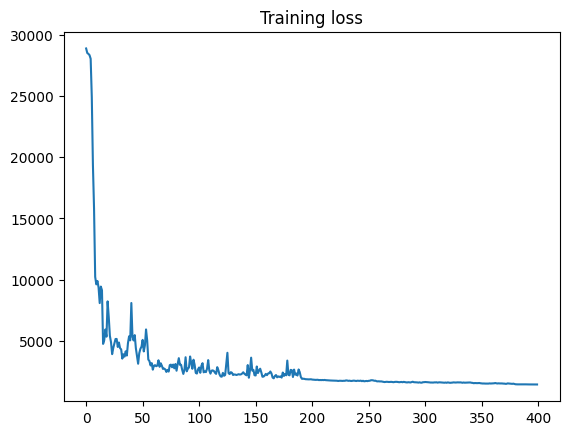

<All keys matched successfully>

In [34]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=240, hidden_size=512, num_layers=2, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=190, gamma=0.1)

# Обучение
num_epochs = 400
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.savefig("loss1.png")
plt.show()

    
torch.save(trained_model.state_dict(), 'lstm_model.pth')
trained_model.load_state_dict(torch.load('lstm_model.pth', weights_only=True))

In [35]:
trained_model = LSTMModel(input_size=240, hidden_size=256, num_layers=4, output_size=1).to(device)
# 
trained_model.load_state_dict(torch.load('37.pth', weights_only=True))

In [36]:
trained_model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
crit = nn.L1Loss()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        x_measure_all = inputs[:, :, ::15] 
        x_measure_avg = x_measure_all.mean(dim=-1)  # Усредняем по радарам
        outputs = trained_model(inputs, x_measure_avg)
        
        
        loss = crit(outputs.squeeze()[:, :], targets[:, :]) 
        test_loss += loss.item()


print(f'Validation Loss: {test_loss/len(test_loader):.8f}')

Validation Loss: 36.61609692


------------------------------------------------------------------------2----------------------------------------------------------------------

In [37]:
# class RadarDataset(Dataset):
#     def __init__(self, X, y, window_size=111, step=7):
#         self.windows_X = []
#         self.windows_y = []
#         
#         for trajectory_idx in range(X.shape[0]):  # 368 траекторий
#             trajectory_X = X[trajectory_idx]  # (16, 1001, 11)
#             trajectory_y = y[trajectory_idx]  # (16, 1001)
#             
#             # Конкатенируем данные от 16 радаров
#             trajectory_X = trajectory_X.transpose(1, 0, 2).reshape(1001, -1)  # (1001, 11*16)
#             trajectory_y = trajectory_y.mean(axis=0)  # Среднее значение x для всех радаров (1001,)
#             
#             for start in range(0, 1001 - window_size, step):
#                 end = start + window_size
#                 self.windows_X.append(trajectory_X[start:end, :])
#                 # self.windows_y.append(trajectory_y[end-1])
#                 self.windows_y.append(trajectory_y[start:end])  # Берем ВСЕ точки окна
# 
#         
#         self.windows_X = torch.tensor(np.array(self.windows_X), dtype=torch.float32)
#         self.windows_y = torch.tensor(np.array(self.windows_y), dtype=torch.float32)
#         
#     def __len__(self):
#         return len(self.windows_X)
#     
#     def __getitem__(self, idx):
#         return self.windows_X[idx], self.windows_y[idx]

In [38]:
# # Создание датасета и DataLoader
# b_size = 128
# train_dataset = RadarDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False)
# 
# test_dataset = RadarDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)
# 
# # Пример батча
# print(len(train_loader), len(test_loader))
# for X_batch, y_batch in train_loader:
#     print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
#     # print(X_batch.view(-1, X_batch.shape[2], X_batch.shape[3]).shape)
#     print(y_batch.shape)  # (16, seq_length)
#     # print(y_batch.view(-1).shape)
#     print(X_batch[0][110][:17], y_batch[0][110])
#     break

In [39]:
import torch.nn as nn

# Функция инициализации весов с помощью метода Xavier
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)  # Инициализация весов
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # Инициализация смещений нулями
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Инициализация весов
        nn.init.constant_(m.bias, 0)  # Инициализация смещений нулями

class LSTMModel(nn.Module):
    def __init__(self, input_size=176, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Полносвязный слой для предсказания координаты x
        self.fc1 = nn.Linear(hidden_size, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
        # self.fc = nn.Linear(hidden_size, output_size)
    
    #residual
    def forward(self, x, x_measure):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)
        out = self.fc1(lstm_out)  # output: (batch, seq_len, 1)
        out = self.act1(out)
        out = self.fc2(out)
        
        return out + x_measure.unsqueeze(-1)

Epoch [1/400], Loss: 30250.499877, L1 120.743161, Avg Abs Diff: 121.677912
Epoch [2/400], Loss: 30377.141767, L1 120.997750, Avg Abs Diff: 121.677912
Epoch [3/400], Loss: 29797.211003, L1 120.176943, Avg Abs Diff: 121.677912
Epoch [4/400], Loss: 29612.663772, L1 119.938316, Avg Abs Diff: 121.677912
Epoch [5/400], Loss: 28345.828873, L1 118.722570, Avg Abs Diff: 121.677912
Epoch [6/400], Loss: 25282.269209, L1 114.174328, Avg Abs Diff: 121.677912
Epoch [7/400], Loss: 20573.024588, L1 103.171759, Avg Abs Diff: 121.677912
Epoch [8/400], Loss: 20319.021056, L1 102.380289, Avg Abs Diff: 121.677912
Epoch [9/400], Loss: 20778.814559, L1 103.839382, Avg Abs Diff: 121.677912
Epoch [10/400], Loss: 16005.819618, L1 88.817706, Avg Abs Diff: 121.677912
Epoch [11/400], Loss: 11332.450884, L1 72.430171, Avg Abs Diff: 121.677912
Epoch [12/400], Loss: 13516.311936, L1 76.294676, Avg Abs Diff: 121.677912
Epoch [13/400], Loss: 9983.499554, L1 66.454986, Avg Abs Diff: 121.677912
Epoch [14/400], Loss: 7949

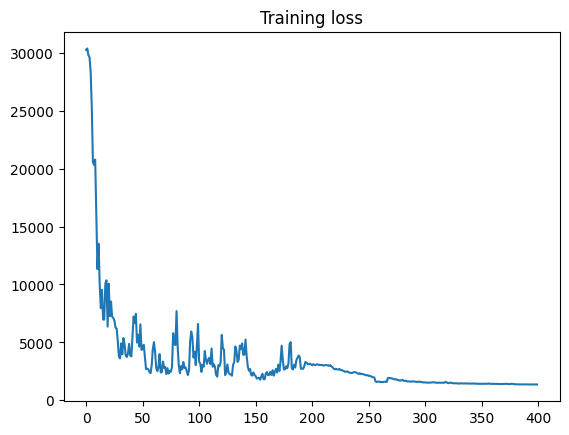

<All keys matched successfully>

In [40]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=240, hidden_size=256, num_layers=3, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=190, gamma=0.1)

# Обучение
num_epochs = 400
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.savefig("loss2.png")
plt.show()

    
torch.save(trained_model.state_dict(), './lstm_model2.pth')
trained_model.load_state_dict(torch.load('./lstm_model2.pth', weights_only=True))

In [41]:
trained_model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
crit = nn.L1Loss()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # x_measure = inputs[:, :, 0].to(device)  # Берем x_measure из входных данных
        
        
        x_measure_all = inputs[:, :, ::15]  # Берем каждый 11-й признак (x_measure от всех радаров)
        x_measure_avg = x_measure_all.mean(dim=-1)  # Усредняем по радарам
        outputs = trained_model(inputs, x_measure_avg)

        loss = crit(outputs.squeeze()[:, 10:], targets[:, 10:]) 
        test_loss += loss.item()


print(f'Validation Loss: {test_loss/len(test_loader):.8f}')

Validation Loss: 37.03004517


In [137]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=176, hidden_size=128, num_layers=3, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Обучение
num_epochs = 200
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

    
torch.save(trained_model.state_dict(), '37.pth')
trained_model.load_state_dict(torch.load('37.pth', weights_only=True))

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 176, got 240

Epoch [1/200], Loss: 0.018134
Epoch [2/200], Loss: 0.000871
Epoch [3/200], Loss: 0.000596
Epoch [4/200], Loss: 0.000479
Epoch [5/200], Loss: 0.000407
Epoch [6/200], Loss: 0.000351
Epoch [7/200], Loss: 0.000324
Epoch [8/200], Loss: 0.000327
Epoch [9/200], Loss: 0.000289
Epoch [10/200], Loss: 0.000263
Epoch [11/200], Loss: 0.000250
Epoch [12/200], Loss: 0.000203
Epoch [13/200], Loss: 0.000177
Epoch [14/200], Loss: 0.000183
Epoch [15/200], Loss: 0.000155
Epoch [16/200], Loss: 0.000184
Epoch [17/200], Loss: 0.000162
Epoch [18/200], Loss: 0.000145
Epoch [19/200], Loss: 0.000141
Epoch [20/200], Loss: 0.000118
Epoch [21/200], Loss: 0.000120
Epoch [22/200], Loss: 0.000113
Epoch [23/200], Loss: 0.000110
Epoch [24/200], Loss: 0.000118
Epoch [25/200], Loss: 0.000112
Epoch [26/200], Loss: 0.000098
Epoch [27/200], Loss: 0.000102
Epoch [28/200], Loss: 0.000095
Epoch [29/200], Loss: 0.000091
Epoch [30/200], Loss: 0.000086
Epoch [31/200], Loss: 0.000087
Epoch [32/200], Loss: 0.000075
Epoch [33/200], L

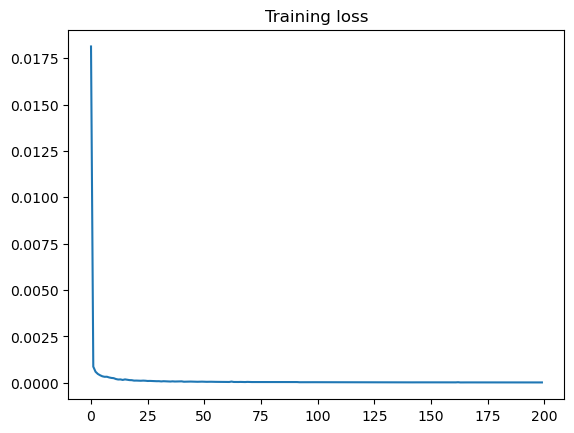

<All keys matched successfully>

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=32, hidden_size=128, num_layers=2, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=1)

# Обучение
num_epochs = 200
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

    
torch.save(trained_model.state_dict(), '37.pth')
trained_model.load_state_dict(torch.load('37.pth', weights_only=True))

------------------------------------------------------------------------------------------------ VALIDATION -----------------------------------------------------------------------


In [26]:
# Тестирование
# train_loader
# test_loader
trained_model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        # inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
        # targets = targets.view(-1).to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = trained_model(inputs)
        # print(outputs, targets)
        # unscaled_out = test_scaler.inverse_transform(outputs.cpu())
        # unscaled_targets = test_scaler.inverse_transform(targets.view(-1, 1).cpu())
        # diff = abs(unscaled_out - unscaled_targets)
        # print(unscaled_out, unscaled_targets)
        # print(diff)
        # print()
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        # test_loss_unscaled += np.sum(diff)

print(f'Validation Loss: {test_loss/len(test_loader):.8f}')
# print(f'Validation Loss_true: {test_loss_unscaled/len(train_loader):.8f}')

Validation Loss: 1.94674204
Validation Loss_true: 2873391.11310649
